In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import contacts

from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

# Contact map by scatter plot - compared to cWW annotation

### Get SoM results

In [3]:
families = [['RF00005', 250], ['RF00059',150], ['RF00023',100], ['RF00010', 100], ['RF00504', 200]]

In [4]:
SS_dict = {'RF00005': '(((((((,,<<<<_______>>>>,<<<<<_______>>>>>,,,,,<<<<<_______>>>>>))))))):',
            'RF00059': '.....<<<<<<<<<<<<<<<<<...>>>>>>.....<<<<<..>>>>>>>>>>>.....<<<<..<<<<<....>>>>>..>>>>..>>>>>............',
          'RF00504': ':::::(((((((((((,<-<<<<<<___>>>>>>><<<---<<<<---<<_____>>---->>>>-->>>,,,,))))))))))):::::'}

In [5]:
f = 4
fam = families[f][0]
numhidden = 512
min_dist = 5.0

#get scores
arrayspath = '../../marks/Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
hol_mut2 = np.load(arrayspath)
seqlen,_, dims,_ = hol_mut2.shape
C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

#get coordinates
C[np.tril_indices(seqlen)] = np.min(C)
bp_stretch = np.ravel(C)
minval = np.sort(bp_stretch)[::-1][-1] #just gets the minimum value - can be changed to a different idx
bs = np.where(C > minval)
idx = np.argsort(C[bs])
x = bs[0][idx] #sorts the x and y coords in order from lowest to highest so highest scores will be plotted last
y = bs[1][idx]

score_col = [C[xx,yy] for xx,yy in zip(x,y)] #gets the scores for each coordinate in the needed order

nest_coords = bd.bp_coords(SS_dict[fam])
nest_coords = nest_coords[:len(nest_coords)//2]

In [6]:
#Load in the EC annotation
ECannotfile = '../../marks/%s/%s.EC.interaction.txt'%(fam,fam) 
EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

######### QUALITATIVE CONTACTS ###########

#Top L/2 EC scores
topEC = EC_df.loc[:seqlen//2, ['Rfam_reduced_position1', 'Rfam_reduced_position2']]
#All cWW annotated interactions
cWW_int = EC_df[EC_df['interactions'] == 'cWW']
#cWW_int = EC_df[(EC_df['interactions'] == 'None') & (EC_df['interactions'] != 'None')]

#All PDB contacts < 8 angstroms
close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 

#get the colour map to select colors for plotting
pal = 'Blues'
cmap = mat.cm.get_cmap(pal)


markersize = families[f][1]

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


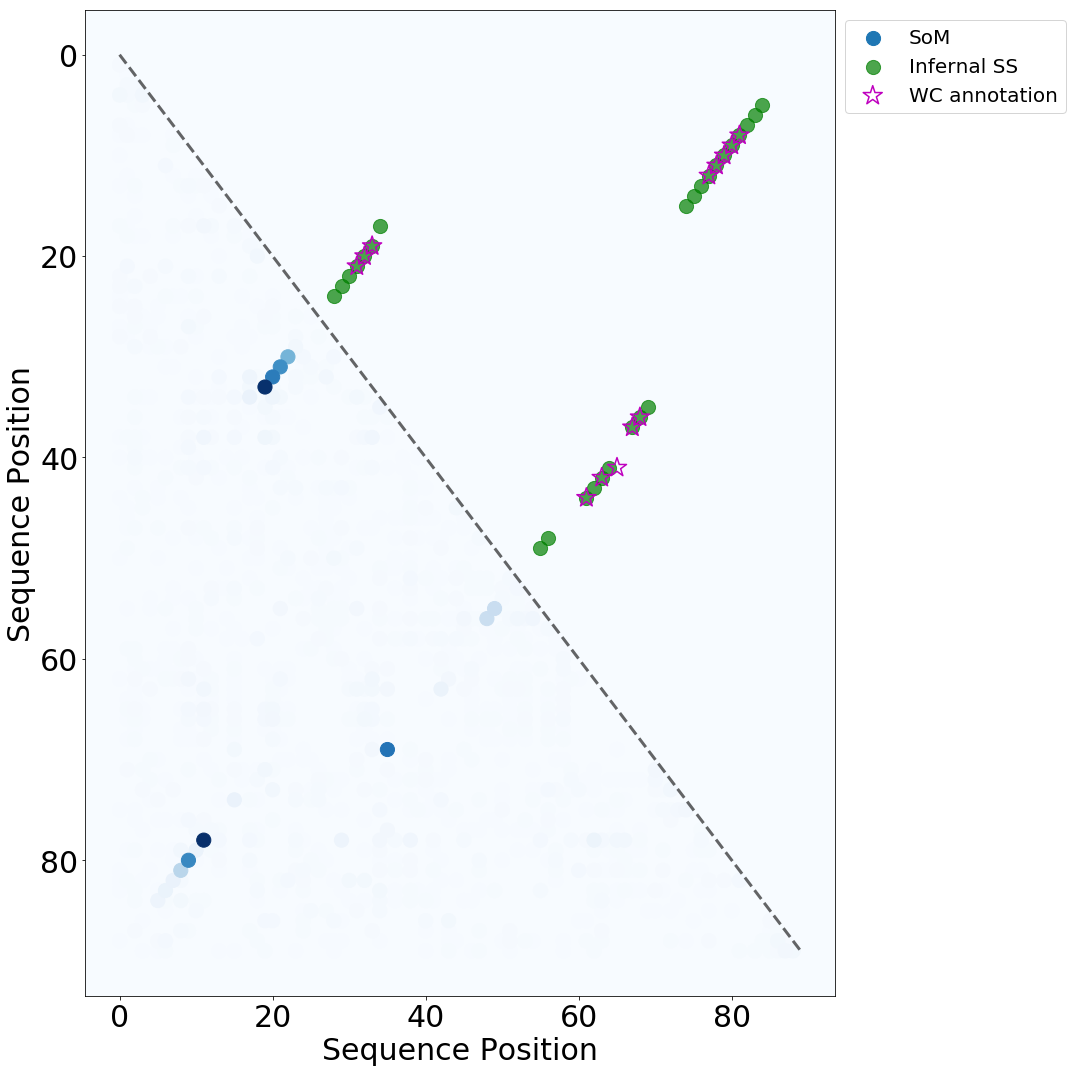

In [10]:
plt.figure(figsize=(15,15))

#ax2 = fig.add_subplot(1,2,1)
plt.scatter(x, y, c=score_col, cmap=pal, label = 'SoM', vmin=0., s=markersize) #plot SoM results
plt.scatter(nest_coords[:, 1], nest_coords[:, 0], c='g', label = 'Infernal SS', s=markersize, alpha=0.7)
plt.scatter(cWW_int.iloc[:, 2], cWW_int.iloc[:, 1], edgecolors='m',
            label= 'WC annotation', facecolors='none', marker='*',s=markersize*2, linewidth=1.5)
plt.plot(range(seqlen), range(seqlen), 'k--', linewidth=3, alpha=0.6)
#plt.title('MLP ', fontsize=30)
#ax2.legend(loc='best', fontsize=20, bbox_to_anchor=(1., 0.5))
plt.xlabel('Sequence Position', fontsize=30)
plt.ylabel('Sequence Position', fontsize=30)
#ax2.set_xlim([0,seqlen])
#ax2.set_ylim([0,seqlen])

ax2 = plt.gca()
ax2.invert_yaxis()
ax2.set_facecolor(cmap(0.))
#ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.legend(loc='best', fontsize=20, bbox_to_anchor=(1., 1.0))


plt.savefig('nestedlegend.pdf')
#plt.savefig('%s_vs_infernal_vs_cWW.pdf'%(fam))
plt.show()